In [41]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters

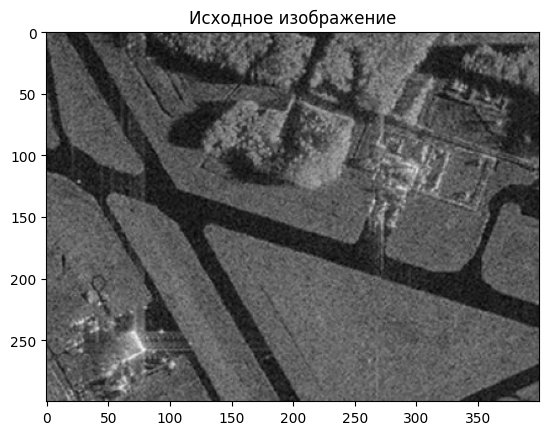

In [42]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
plt.imshow(image_gray, cmap="gray")
plt.title("Исходное изображение")
plt.show()


In [43]:
# критерий однородности на основе среднего значения
def homo_average(img, mask, point, T): 
    # среднее значение в регионе:
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0]) 
    if abs(av_val - img[point]) <= T:
        return True
    return False

In [44]:
# критерий однородности на основе медианы
def homo_median(img, mask, point, T):
    if np.count_nonzero(mask) > 0:
        # вычисляем медиану значений в регионе:
        median_val = np.median(img[mask > 0])
        if abs(median_val - img[point]) <= T:
            return True
    return False

In [45]:
# алгоритм разрастания регионов
def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i,j] == 0 and mask[i - r:i + r, j - r: j + r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask
    return mask * 255

# 1. Подберите параметры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.

(np.float64(-0.5), np.float64(399.5), np.float64(299.5), np.float64(-0.5))

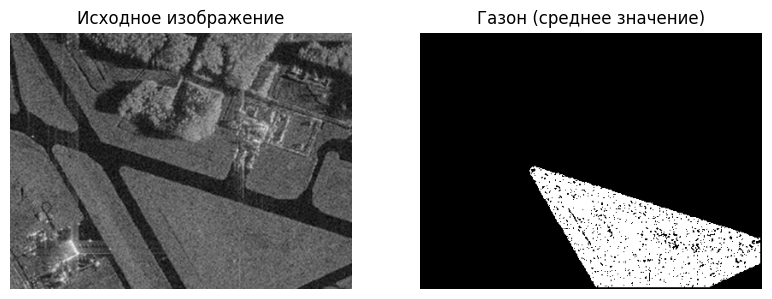

In [46]:
seed_point = (250, 250)  
mask_lawn_avg = region_growing(image_gray, seed_point, homo_average, 2, 15)  

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_gray, cmap="gray")
plt.title("Исходное изображение")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_lawn_avg, cmap="gray")
plt.title("Газон (среднее значение)")
plt.axis('off')

# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.

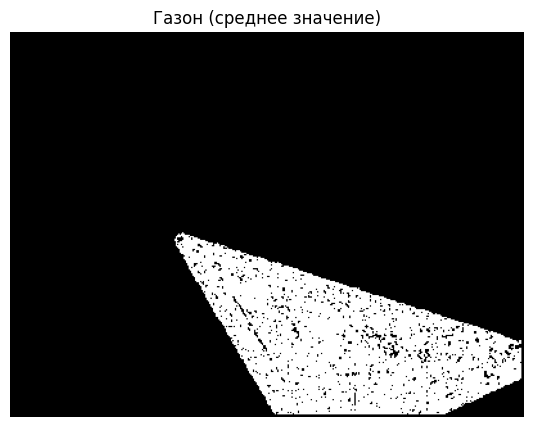

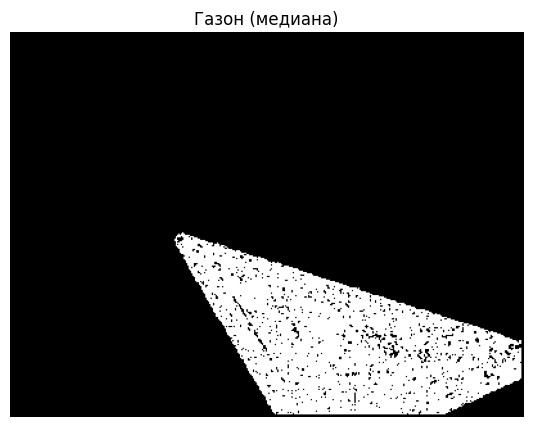

Сравнение критериев однородности:
Пикселей выделено средним: 19437
Пикселей выделено медианой: 19475


In [51]:
mask_lawn_median = region_growing(image_gray, seed_point, homo_median, 2, 15)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(mask_lawn_avg, cmap="gray")
plt.title("Газон (среднее значение)")
plt.axis('off')


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
plt.imshow(mask_lawn_median, cmap="gray")
plt.title("Газон (медиана)")
plt.axis('off')
plt.show()

# Сравнение результатов
print("Сравнение критериев однородности:")
print(f"Пикселей выделено средним: {np.count_nonzero(mask_lawn_avg)}")
print(f"Пикселей выделено медианой: {np.count_nonzero(mask_lawn_median)}")

# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

In [48]:
palm_image = cv2.imread('palm_1.jpg') 
palm_rgb = cv2.cvtColor(palm_image, cv2.COLOR_BGR2RGB)
palm_gray = cv2.cvtColor(palm_image, cv2.COLOR_BGR2GRAY)

# бинаризация 
blurred = cv2.GaussianBlur(palm_gray, (5, 5), 0) 
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)

_, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)

_, markers = cv2.connectedComponents(sure_fg)

result_image = palm_image.copy()

markers = cv2.watershed(result_image, markers.astype(np.int32))  

# отрисовка границ пальм 
result_image[markers == -1] = [0, 0, 255]  

# подсчет деревьев
palm_count = len(np.unique(markers)) - 1


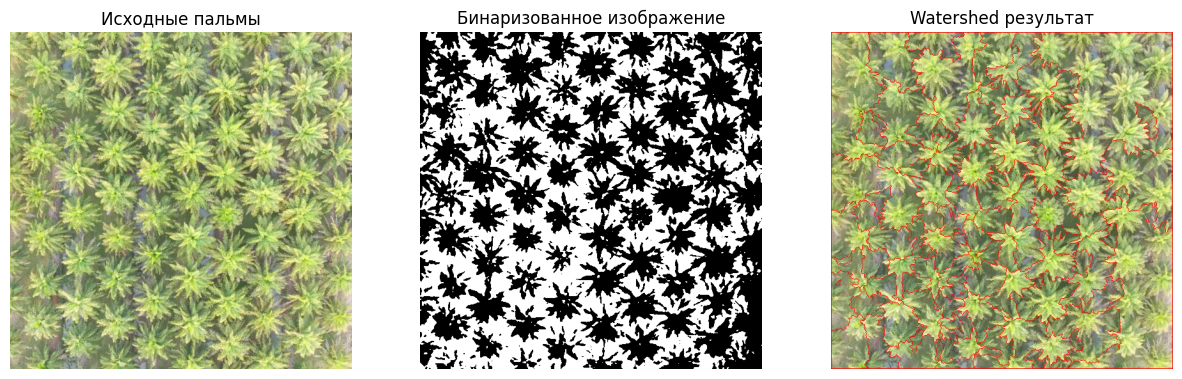

Количество пальмовых деревьев: 106


In [49]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(palm_rgb)
plt.title("Исходные пальмы")
plt.axis('off')
   
plt.subplot(1, 3, 2)
plt.imshow(binary, cmap='gray')
plt.title("Бинаризованное изображение")
plt.axis('off')
    
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title("Watershed результат")
plt.axis('off')
plt.show()
    
print(f"Количество пальмовых деревьев: {palm_count}")